## idk but ...

- task J1 (image classification on CIFAR-10)
- testee M perform J1 on dataset T to let the tester decide difficulty using error rate
- target task excueter on J2 deciding meaningfulness of the data (how?)




### Things to write

- data encoder: autoencoder to create latent represent
- data bank: original data and adversarials and also augmented data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as func
import torch.nn.init as torch_init
import torch.optim as optim
import pandas as pd
import torchvision
from torchvision import transforms, utils
from torchvision import models
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import time
import copy
import pickle

In [2]:
from data_augmentation import *
from adv_generate import *

In [3]:
# Check if CUDA is supported
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [4]:
load_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
                                    # same normalize as EfficientNet paper
# cifar-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=load_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=load_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

In [343]:
i = 0
for d in trainloader:
    data = d
    break

In [5]:
def inplace_data_manipulation(data_batch, target_batch, model, p=0.1, eps=0.03):
    '''
    data_batch: n_batch x 3 x 32 x 32
    '''
    for i in range(data_batch.shape[0]):
        data = data_batch[i:(i+1)]
        target = target_batch[i:(i+1)]
        
        rand_num = np.random.rand()
        
        if rand_num < p:
            data_batch[i] = inplace_adv(data.detach(), target, model, eps=eps)
        elif rand_num < 2*p:
            data_batch[i] = inplace_transform(data[0])
        
    return data_batch

In [323]:
# load EfficientNet
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b1')

# change fc output class numbers
model._fc.out_features = 10

Loaded pretrained weights for efficientnet-b1


In [344]:
_ = model.eval()
dd = copy.deepcopy(data[0])
db = inplace_data_manipulation(data[0], data[1], model, p = 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


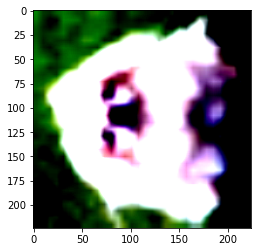

In [304]:
dog = copy.deepcopy(dd[1])
plt.imshow(dog.transpose(0,2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


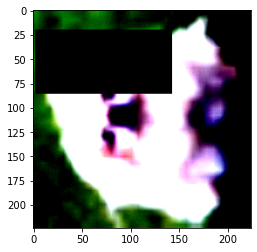

In [305]:
plt.imshow(inplace_transform(dog).transpose(0,2))

### target task executor

In [6]:
# define an arbitrary reasonable cnn for classification
class my_executor(nn.Module):
    def __init__(self):
        super(my_executor, self).__init__()
        self.in_dim = 224*224*3
        self.out_dim = 10
        self.linear = nn.Linear(self.in_dim, self.out_dim)

        
    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)
        
        # linear layer
        x = self.linear(x)
        return x

executor = my_executor()

In [7]:
def epoch_train(model, optimizer, trainloader, criterion, computing_device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for data in trainloader:
        data, target = data[0].to(computing_device), data[1].to(computing_device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct/len(trainloader.dataset)
    
    return train_loss, train_accuracy

In [50]:
# get average performance of executor to decide criterion of meaningful data
n_epoch = 20
train_loss = []
train_acc = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(executor.parameters(), lr=0.001, momentum=0.9)

executor = executor.to(computing_device)
    
for epoch in range(n_epoch):
    loss,acc = epoch_train(executor, optimizer, trainloader, criterion, computing_device)
    train_loss.append(loss)
    train_acc.append(acc)
    print("Epoch" + str(epoch) + " : train loss " + str(loss) + ", train accuracy " + str(acc))
        

Epoch0 : train loss 1.2541510941696168, train accuracy 25.25
Epoch1 : train loss 1.2822467457199096, train accuracy 26.972
Epoch2 : train loss 1.2261524297142028, train accuracy 27.09
Epoch3 : train loss 1.2385496545028687, train accuracy 27.342
Epoch4 : train loss 1.2272757942199708, train accuracy 27.814
Epoch5 : train loss 1.2106962385177613, train accuracy 28.166
Epoch6 : train loss 1.2043662620162965, train accuracy 28.064
Epoch7 : train loss 1.2053166363143921, train accuracy 28.438
Epoch8 : train loss 1.245542635612488, train accuracy 28.522
Epoch9 : train loss 1.2187507434654237, train accuracy 28.618
Epoch10 : train loss 1.2099693603134156, train accuracy 28.702
Epoch11 : train loss 1.2023860532379151, train accuracy 29.23
Epoch12 : train loss 1.1911020780563355, train accuracy 29.14
Epoch13 : train loss 1.1732371284866332, train accuracy 29.13
Epoch14 : train loss 1.2054364381790161, train accuracy 29.014
Epoch15 : train loss 1.2167941747283935, train accuracy 29.312
Epoch16 

In [51]:
train_loss = np.array(train_loss)/32 # per example loss

In [52]:
# save results
np.save('result/train_loss_per_example_executor.npy', train_loss)
np.save('result/train_acc_executor.npy', train_acc)

# save model weights
torch.save(executor.state_dict(), 'model/executor_baseline.pth')

In [310]:
accs = []
i = 0

for data in trainloader:
    model = my_executor()
    model.to(computing_device)
    
    data, target = data[0].to(computing_device), data[1].to(computing_device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    _ = model.eval()
    output = model(data)
    _, preds = torch.max(output.data, 1)
    
    acc = torch.sum(target == preds).item()
    accs.append(acc)
    
    i += 1 
    
    if i == 100:
        break
   

In [345]:
executor = my_executor()
executor.load_state_dict(torch.load('model/executor_baseline.pth'))

<All keys matched successfully>

In [346]:
optimizer.zero_grad()
outputs = executor(dd)
loss = criterion(outputs, data[1])
loss.backward()
optimizer.step()

In [347]:
_ = executor.eval()
outputs = executor(db)
_, predicted = torch.max(outputs.data, 1)

In [8]:
def train_executor(ex, tensor, target, lr=0.001, momentum=0.9):
    '''
    tensor: n_batch x 224 x 224 x 3
    '''
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ex.parameters(), lr=lr, momentum=momentum)
    
    optimizer.zero_grad()
    outputs = ex(tensor)
    loss = criterion(outputs, target)
    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    _ = ex.eval()
    outputs = ex(tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    acc = torch.sum(target == predicted).item() /tensor.shape[0]
    
    return (loss.data/tensor.shape[0]).item(), acc


# measure meaningfulness of data using loss and accuracy
def meaningful_measure(ex, tensor, target, acc_ratio=0.8, loss_ratio=1.2, acc_criteria=0.296, loss_criteria=0.0363):
    loss,acc = train_executor(ex, tensor, target)
    
    if acc > acc_ratio*acc_criteria and loss < loss_ratio*loss_criteria:
        return True
    return False

In [383]:
ex = my_executor()
meaningful_measure(ex, dd, data[1])

0.01863095909357071 0.40625


True

### LPT

In [9]:
import gc

In [10]:
# load EfficientNet
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b1')

# change fc output class numbers
model._fc.out_features = 10

Loaded pretrained weights for efficientnet-b1


In [11]:
# test and return accuracy
def testing(model, testloader, criterion, computing_device):
    # make sure model is in evaluation mode
    model.eval()
    val_loss = 0.0
    val_correct = 0
    test_batch_loss = []
    for data in testloader:
        data, target = data[0].to(computing_device), data[1].to(computing_device)
        output = model(data)
        loss = criterion(output, target)
        
        #test_batch_loss.append(loss)
        val_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_correct += (preds == target).sum().item()
        
        del data
        del target
        del output
        del loss
        gc.collect()
    
    val_loss = val_loss/len(testloader.dataset)
    val_accuracy = 100.0 * val_correct/len(testloader.dataset)
    
    return val_loss, val_accuracy

# suppose all input parameters are on the same computing device
def train_batch(model, optimizer, data, target, criterion, computing_device):
    
    model.train()
    train_loss = 0.0
    train_correct = 0
    
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    train_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    train_correct += (preds == target).sum().item()
    loss.backward()
    optimizer.step()
    
    train_loss = train_loss/data.shape[0]
    train_accuracy = 100.0 * train_correct/len(trainloader.dataset)
    
    return train_loss, train_accuracy

In [ ]:
learning_rate = 0.001
momentum = 0.9
n_epoch = 30
p = 0.25


train_loss = []
train_acc = []
test_loss = []
test_acc = []


# define optimizer and loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

# bring model to computing device
model = model.to(computing_device)
best_model_weights = copy.deepcopy(model.state_dict()) 


for epoch in range(n_epoch):
    n_batch = 0
    batch_loss = 0
    batch_acc = 0
    
    for data, target in trainloader:
        # data augmentation and adv generation
        data = data.to(computing_device)
        target = target.to(computing_device)
        
        data = inplace_data_manipulation(data, target, model, p = p)
        
        ex = my_executor().to(computing_device)
        if True:
        #if meaningful_measure(ex, data, target):
            #del ex
            loss,acc = train_batch(model, optimizer, data, target, criterion, computing_device)
            #batch_loss += loss
            #batch_acc += acc
            #n_batch += 1
            #p += 0.01
            #if p > 0.2:
            #    p = 0.2
            
        else: 
            p -= 0.01
            if p < 0:
                p = 0
        
        # free my poor gpu memory please
        del data
        del target
        gc.collect()
         
    loss,acc = testing(model, trainloader, criterion, computing_device)
    train_loss.append(loss)
    train_acc.append(acc)
    print("Epoch" + str(epoch) + " : train loss " + str(loss) + ", train accuracy " + str(acc))
    
    loss,acc = testing(model, testloader, criterion, computing_device)
    test_loss.append(loss)
    test_acc.append(acc)
    print("Epoch" + str(epoch) + " : test loss " + str(loss) + ", test accuracy " + str(acc))

    
    ##################early stop####################
    # early stop if validation loss increased
    if(epoch > 5):
        before = test_loss[-2]
        after = test_loss[-1]
        if (before < after and test_acc[-2] > test_acc[-1]):
            break
        else:
            best_model_weights = copy.deepcopy(model.state_dict())
            
model.load_state_dict(best_model_weights)        


In [13]:
# save model weights
torch.save(model.state_dict(), 'model/efficient_net_b1_da_at_P025.pth')

# save results
np.save('result/train_loss_b1_da_at_P025.npy', train_loss)
np.save('result/train_acc_b1_da_at_P025.npy', train_acc)
np.save('result/test_loss_b1_da_at_P025.npy', test_loss)
np.save('result/test_acc_b1_da_at_P025.npy', test_acc)

In [16]:
for data, target in trainloader:
    data = data.to(computing_device)
    target = target.to(computing_device)
    
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


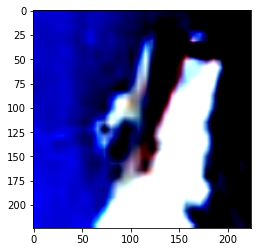

In [26]:
plt.imshow(data[0].detach().cpu().transpose(0,2))

In [21]:
_

tensor([6.8706, 6.3404, 5.3895, 6.7376, 4.6097, 7.4837, 7.3588, 5.0283, 5.4898,
        6.4168, 4.9304, 9.0608, 5.5153, 8.1837, 5.2931, 7.1871, 8.2493, 6.0196,
        6.9407, 7.2613, 6.2533, 5.8525, 7.6125, 6.9094, 7.4494, 5.0314, 6.7706,
        8.5148, 7.6214, 9.8863, 4.9888, 7.2995], device='cuda:0')

In [18]:
model._fc

Linear(in_features=1280, out_features=10, bias=True)